# CNN:

En el presente trabajo desarrollamos una CNN para la detección de distintos rostros.

Primero importamos las librerías necesarias para este procedimiento. Esta implementación en particular utiliza python 3.7 y tensorflow 1.0.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
tf.reset_default_graph()
from sklearn.model_selection import train_test_split
from random import randint

print('Librerias cargadas correctamente')

C:\Users\ASUS\Anaconda3\envs\tf1_4py3_7\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ASUS\Anaconda3\envs\tf1_4py3_7\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ASUS\Anaconda3\envs\tf1_4py3_7\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\ASUS\Anaconda3\envs\tf1_4py3_7\lib\site-packages\ten

Librerias cargadas correctamente


Seguidamente definimos un diccionario con las clases participantes en el experimento.

In [2]:
label_dict = {
 0: 'Alonso',
 1: 'Anabel',
 2: 'Dave',
 3: 'Elard',
 4: 'Harry',
 5: 'Rodrigo',
}

In [3]:
img_height = 104 # Altura y ancho de cada imagen
img_width = 104

n_class = 6 # Numero de clases participantes,
n_examples_per_class_training = 30 # Numero de ejemplos por cada clase.

image_r = "tf_record/train_clase/img_batch.txt" # Dirección del archivo con todas las imágenes preprocedas.
label_r = "tf_record/train_clase/label_batch.txt" # Dirección del archivo con todas las etiquetas de cada imagen.

In [4]:
#Reescalando imágenes de entrenamiento y prueba, verificando tamaño de las imágenes
train_x = np.loadtxt(image_r).reshape(n_class*n_examples_per_class_training, img_height, img_width, 1)
train_y = np.loadtxt(label_r).reshape(n_class*n_examples_per_class_training, n_class)

test_x = train_x[:20]
test_y = train_y[:20]

evaluation_x = train_x[20:30] 
evaluation_y = train_y[20:30]

train_x = train_x[30:]
train_y = train_y[30:]

#train_x, train_y, test_x, test_y = train_test_split(train_x, train_y, test_size=0.2, shuffle=False)

print('Dimensiones del conjunto de imagenes: ', train_x.shape, train_y.shape) 
print('Dimensiones del conjunto de prueba: ', test_x.shape, test_y.shape)
print('Dimensiones del conjunto de evaluacion: ', evaluation_x.shape, evaluation_y.shape) 

Dimensiones del conjunto de imagenes:  (150, 104, 104, 1) (150, 6)
Dimensiones del conjunto de prueba:  (20, 104, 104, 1) (20, 6)
Dimensiones del conjunto de evaluacion:  (10, 104, 104, 1) (10, 6)


Text(0.5, 1.0, '(Label: Harry)')

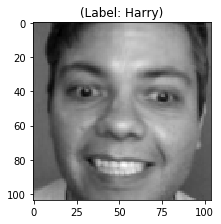

In [5]:
#Mostrando la primera imagen en el conjunto de entrenamiento
plt.figure(figsize=[7, 7])
plt.subplot(121)
selected_image = 19
curr_img = np.reshape(test_x[selected_image], (104, 104))
curr_lbl = np.argmax(test_y[selected_image,:])
plt.imshow(curr_img, cmap='gray')
plt.title( "(Label: " + str(label_dict[curr_lbl]) + ")" )  

# Parametros de la Red Neuronal

In [6]:
training_iter = 100 # Numero de iteracciones
learning_rate = 0.001 # Learning rate 
batch_size = 10 # Tamaño de lote ingresante a la red. Un valor muy grande pude agotar la memoria.
n_input = 104 

In [7]:
# Instanciando placeholders
x = tf.placeholder("float", [None, 104, 104, 1])
y = tf.placeholder("float", [None, n_class])

In [8]:
# Función de Convolución 
def conv2d(x, W, b, strides=1): # x->Input, W->weights, b->bias and strides   
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

# Función de pooling
def maxpool2d(x, k=2): # x->Input, k->KernelSize
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')

In [9]:

weights = {
    'wc1': tf.get_variable('W0', shape=(3, 3, 1, 32), initializer=tf.contrib.layers.xavier_initializer() ),
    'wc2': tf.get_variable('W1', shape=(3, 3, 32, 64), initializer=tf.contrib.layers.xavier_initializer() ),
    'wc3': tf.get_variable('W2', shape=(3, 3, 64, 128), initializer=tf.contrib.layers.xavier_initializer() ),
    'wc4': tf.get_variable('W3', shape=(3, 3, 128, 256), initializer=tf.contrib.layers.xavier_initializer() ),
    'wd1': tf.get_variable('W4', shape=(7*7*256, 256), initializer=tf.contrib.layers.xavier_initializer() ), # Considerar que 14*14 representa la octava parte del tamaño en la imagen original
    'out': tf.get_variable('W6', shape=(256, n_class), initializer=tf.contrib.layers.xavier_initializer() ),      
}


biases = {
    'bc1': tf.get_variable('B0', shape=(32), initializer=tf.contrib.layers.xavier_initializer()),       
    'bc2': tf.get_variable('B1', shape=(64), initializer=tf.contrib.layers.xavier_initializer()),
    'bc3': tf.get_variable('B2', shape=(128), initializer=tf.contrib.layers.xavier_initializer()),
    'bc4': tf.get_variable('B3', shape=(256), initializer=tf.contrib.layers.xavier_initializer()),
    'bd1': tf.get_variable('B4', shape=(256), initializer=tf.contrib.layers.xavier_initializer()),
    'out': tf.get_variable('B5', shape=(n_class), initializer=tf.contrib.layers.xavier_initializer()),
}

print('Arquitectura definida correctamente')


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Arquitectura definida correctamente


In [10]:
# Definiendo función de entrenamiento para la CNN
def conv_net(x, weights, biases): 
    conv1 = conv2d(x, weights['wc1'], biases['bc1']) # Primera convolución
    conv1 = maxpool2d(conv1, k=2) 
    
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2']) # Segunda convolución
    conv2 = maxpool2d(conv2, k=2)
    
    conv3 = conv2d(conv2, weights['wc3'], biases['bc3']) # Tercera convolución
    conv3 = maxpool2d(conv3, k=2)
    
    conv4 = conv2d(conv3, weights['wc4'], biases['bc4']) # Cuarta convolución
    conv4 = maxpool2d(conv4, k=2)
    
    fc1 = tf.reshape(conv4, [-1, weights['wd1'].get_shape().as_list()[0] ]) # Fully connected layers
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']),  biases['bd1']) 
    fc1 = tf.nn.relu(fc1)

    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

# Entrenamiento

In [11]:
# Funciones para el entrenamiento
pred = conv_net(x, weights, biases) 
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) # Función optimizer requiere de función cost y esta a su vez de pred.

# Funciones para la prueba
get_predict = tf.argmax(pred, 1)
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1)) #  Verificamos si el resultado coincide con el label de la imagen,
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)) #  Calculando accuracy entre todas las imágenes y retornando un promedio de esos resultads.

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [12]:
init = tf.global_variables_initializer() # Inicializando variables

In [13]:
sess = tf.Session()

sess.run(init) # Iniciamos las variables del diccionario
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = [] 

summary_writer = tf.summary.FileWriter('./Output', sess.graph)
#for i in range(training_iter):
for i in range(30):
    for batch in range(len(train_x) // batch_size): # Dividimos el grupo de entrenamiento en lotes para no estresar la memoria
        batch_x = train_x[batch*batch_size:min((batch+1)*batch_size, len(train_x))]
        batch_y = train_y[batch*batch_size:min((batch+1)*batch_size, len(train_y))]
        # Ejecutando optimizacion op calculando perdida y accuracy en lote
        opt = sess.run(optimizer, feed_dict={x: batch_x, y: batch_y }) 
        loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x, y: batch_y})
        
    print("Iteraccion ", str(i) + ", Perdida = " + "{:.6f}".format(loss) + ", Accuracy: " + "{:.5f}".format(acc))
    print("Optmización Finalizada")

        
#Calculamos el accuracy de las imagenes en el dataset
test_acc, valid_loss = sess.run([accuracy, cost], feed_dict={x: test_x, y: test_y})
train_loss.append(loss)
test_loss.append(valid_loss)
train_accuracy.append(acc)
test_accuracy.append(test_acc)
print("Calidad del Testing", "{:.5f}".format(test_acc))

summary_writer.close()    
    

Iteraccion  0, Perdida = 1.061268, Accuracy: 0.30000
Optmización Finalizada
Iteraccion  1, Perdida = 0.000887, Accuracy: 1.00000
Optmización Finalizada
Iteraccion  2, Perdida = 0.000062, Accuracy: 1.00000
Optmización Finalizada
Iteraccion  3, Perdida = 0.003105, Accuracy: 1.00000
Optmización Finalizada
Iteraccion  4, Perdida = 0.001185, Accuracy: 1.00000
Optmización Finalizada
Iteraccion  5, Perdida = 0.000020, Accuracy: 1.00000
Optmización Finalizada
Iteraccion  6, Perdida = 0.000012, Accuracy: 1.00000
Optmización Finalizada
Iteraccion  7, Perdida = 0.000009, Accuracy: 1.00000
Optmización Finalizada
Iteraccion  8, Perdida = 0.000007, Accuracy: 1.00000
Optmización Finalizada
Iteraccion  9, Perdida = 0.000005, Accuracy: 1.00000
Optmización Finalizada
Iteraccion  10, Perdida = 0.000003, Accuracy: 1.00000
Optmización Finalizada
Iteraccion  11, Perdida = 0.000002, Accuracy: 1.00000
Optmización Finalizada
Iteraccion  12, Perdida = 0.000001, Accuracy: 1.00000
Optmización Finalizada
Iteraccio

Prediccion obtenida:  4


Text(0.5, 1.0, '(Original: Harry - Predicho: Harry)')

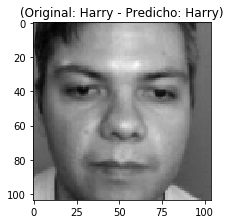

In [42]:
random_evaluation = randint(0, train_x.shape[0]-1)
validation_x = train_x[random_evaluation:random_evaluation+1]
validation_y = train_y[random_evaluation:random_evaluation+1]

#random_evaluation = randint(0, evaluation_x.shape[0]-1)
#validation_x = evaluation_x[random_evaluation:random_evaluation+1]
#validation_y = evaluation_y[random_evaluation:random_evaluation+1]


#Prediciendo posible resultado
get_prediction = sess.run(get_predict, feed_dict={x: validation_x, y:validation_y})
print("Prediccion obtenida: ", get_prediction[0])

#Mostrando la primera imagen en el conjunto de entrenamiento
plt.figure(figsize=[7, 7])
plt.subplot(121)
curr_img = np.reshape(validation_x[0], (104, 104))
curr_original = np.argmax(validation_y[0])
curr_lbl = get_prediction[0]

plt.imshow(curr_img, cmap='gray')
plt.title( "(Original: " +  str(label_dict[curr_original]) + " - Predicho: " + str(label_dict[curr_lbl]) + ")" )  
